# Initialization

## Load packages

In [1]:
%%capture
# Run this code to prevent matplotlib errors
import matplotlib.pyplot as plt
plt.plot([0,1], [0,1])

# Ensure TrueType fonts are used
plt.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
plt.rcParams['ps.fonttype']  = 42  # Use TrueType fonts

In [2]:
## Import packages
import numpy as np
from models.NODE_REN import NODE_REN
import torch
import time
from math import pi as pi
from torchdiffeq import odeint_adjoint as odeint
import scipy as sp
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader, TensorDataset
from scipy.interpolate import interp1d
import copy
import pickle # For saving variables

import cProfile

## Script options

In [3]:
# Paths for saving/loading data and options to save/load data
path_SG  = "data/Data_SG.pkl"
load_SG  = 1
save_SG  = 0
sim_SG   = 0
run_only_SG = 0

path_sys = "data/Data_sys.pkl"
load_sys = 1
save_sys = 0
sim_sys  = 0

path_mm  = "data/Data_mm.pkl"
load_mm  = 1
save_mm  = 0

path_mod = "data/Data_model.pkl"
load_mod = 1
save_mod = 0
sim_mod  = 0

path_mult= "data/Data_mult.pkl"
load_mult= 1
save_mult= 0
sim_mult = 0

savefigs = 0

In [4]:
if not(load_SG):
    # General NodeREN options
    sigma        = 'tanh'
    alpha_mod    = 0
    epsilon      = 5.0e-4
    device       = 'cpu'
    
    # Simulation settings for dopri5
    sim_method   = 'dopri5'
    atol         = 1e-8
    rtol         = 1e-8

In [5]:
# Time vector for model simulation
t_end   = 10
t_start = 0.0
n_steps = 2000

## Preliminary definitions

In [6]:
# Dummy zero input
def zero_input(t):
    return torch.Tensor(0)

In [7]:
# Create an interconnection between a linear harmonic oscillator (LHO) and a c-nodeREN
# def interconnect_LHO_with_nodeREN(Shat,Lhat,SGtilde,SG,D12_star):
def interconnect_LHO_with_nodeREN(Stilde,Ltilde,SGtilde,SG,nq):
    # Inputs:
        # Stilde (ntau times ntau): real matrix with simple eigenvalues on the imaginary axis
        # Ltilde (mtilde times ntau): any real matrix
        # SGtilde: c-nodeREN with nxtilde states, nqtilde neurons, mtilde inputs, and m outputs
        # SG: c-nodeREN with ntau+nxtilde states, nqtilde neurons, 0 inputs, and m outputs
        # nq: number of neurons

    # Update A matrix
    A1 = torch.cat((Stilde, torch.zeros(len(Stilde),len(SGtilde.sys.A.data))),-1)
    A2 = torch.cat((torch.mul(SGtilde.sys.B2.data,Ltilde),SGtilde.sys.A.data),-1)
    A  = torch.cat((A1,A2))
    SG.sys.A.data = A
    
    # Update B1 matrix
    SG.sys.B1.data = torch.cat((torch.zeros(len(Stilde),nq),SGtilde.sys.B1.data))
    # There is no B2 matrix
    
    # Update C matrices
    SG.sys.C1.data = torch.cat((torch.mul(SGtilde.sys.D12.data,Ltilde),SGtilde.sys.C1.data),-1)
    SG.sys.C2.data = torch.cat((torch.mul(SGtilde.sys.D22.data,Ltilde),SGtilde.sys.C2.data),-1)
    
    # Update bias terms (these should be zero according to the paper)
    SG.sys.bx.data = torch.cat((torch.zeros(len(Stilde),1),SGtilde.sys.bx))
    # SG.sys.by.data = SG.sys.by.data*0
    # bv does not change

    return SG

In [8]:
# Perform (regularised) linear least squares on steady-state data
def Linear_least_squares_mm(tau_sim,SG,time_vector,f,w,n_SG,nqtilde,nyhat,lamb):
    # Perform linear least-squares regression to find Xi, and Omega
    # Only use data of the last steady-state period
    
    # Set up regression matrix
    # Linear in tau term
    tau_sim_squeezed = torch.squeeze(tau_sim)
    phi_1 = tau_sim_squeezed.t()
    # Nonlinear term
    phi_2 = w
    
    phi = torch.cat((phi_1,phi_2))
    
    Y = np.squeeze(y_sim.detach().numpy())
    Phi = phi.t().detach().numpy()
    
    # Find indices of the last period
    ind = (time_vector>t_end-1/f).nonzero()
    
    # Perform (regularised) regression
    if lamb > 0:
        alpha = np.squeeze(np.linalg.lstsq(np.squeeze(Phi[ind,:]).T.dot(np.squeeze(Phi[ind,:])) + lamb * np.identity(n_SG+nqtilde), np.squeeze(Phi[ind,:]).T.dot(Y[ind]),rcond=None)[0])
    else:
        alpha = np.squeeze(np.linalg.lstsq(np.squeeze(Phi[ind,:]), Y[ind], rcond=None)[0]) 

    # Unpack solution
    Xi = alpha[0:n_SG]
    Omega = alpha[n_SG:n_SG+nqhat]

    return Xi, Omega, Phi, alpha, Y, ind

In [12]:
def update_Mod_mm(Mod_mm,SG,B2hat,D12hat,Xi,Omega):
    # Notice there are no bias terms
    
    # Make sure B2hat is such that A is Hurwitz
    Mod_mm.sys.B2.data = torch.Tensor(B2hat) # This is a 'free variable' - it is used to enforce additional properties
    Mod_mm.sys.A.data  = SG.sys.A.data - torch.matmul(Mod_mm.sys.B2.data,SG.sys.C2.data)
    Mod_mm.sys.B1.data = SG.sys.B1.data - torch.matmul(Mod_mm.sys.B2.data,SG.sys.D21.data)
    
    Mod_mm.sys.D12.data = torch.Tensor(D12hat)  # This is a 'free variable' - it is used to enforce additional properties
    Mod_mm.sys.C1.data  = SG.sys.C1.data - torch.matmul(Mod_mm.sys.D12.data,SG.sys.C2.data)
    Mod_mm.sys.D11.data = SG.sys.D11.data - torch.matmul(Mod_mm.sys.D12.data,SG.sys.D21.data)
    
    # To match the output equation
    # Mod_mm.sys.D22.data = torch.randn(ny,nu) # This is a free variable
    Mod_mm.sys.C2.data  = torch.Tensor([Xi]) - torch.matmul(Mod_mm.sys.D22.data,SG.sys.C2.data)
    Mod_mm.sys.D21.data = torch.Tensor([Omega]) - torch.matmul(Mod_mm.sys.D22.data,SG.sys.D21.data)

# Signal generator

## Load data

In [13]:
# Load SG (and related variables)
if load_SG:
    with open(path_SG, 'rb') as f:
        ntautilde,mtilde,m,f0,Stilde,Ltilde,SGtilde,n_SG,nyhat,nuhat,nqhat,nqtilde,SG,tau0,tau_sim,u_sim,w_sim,elapsed_time_SG,input_func_temp,t_end,t_start,n_steps_,time_vector_,sim_method,rtol,atol,sigma,device,alpha_mod,epsilon = pickle.load(f)

    def input_func(t):
        return torch.Tensor(input_func_temp(t)).unsqueeze(-1)

time_vector = torch.linspace(t_start, t_end, n_steps)

## Harmonic oscillator

In [15]:
if not(load_SG):
    # Harmonic oscillator
    ntautilde = 2
    mtilde    = 1
    
    # Wave frequency
    f0 = 1
    
    arr = [[0, 1],[-1, 0]]
    Stilde = torch.mul(torch.Tensor(arr),torch.Tensor([2*pi*f0]))
    Ltilde = torch.randn(mtilde,ntautilde)

## Contracting NodeREN

In [16]:
if not(load_SG):
    # nodeREN for signal generator
    nxtilde = 4
    m       = 1
    nqtilde = 8
    
    # Generate contractive signal generator
    mode_sg = 'c'
    SGtilde = NODE_REN(nxtilde, m, mtilde, nqtilde, sigma, epsilon, mode=mode_sg,
                     device=device, bias = 0, alpha=alpha_mod).to(device)
    
    # Remove parameters
    for param in SGtilde.parameters():
        param.requires_grad = False
    SGtilde.updateParameters()
    
    SGtilde.sys.D21.data = SGtilde.sys.D21.data*0

## Interconnection and simulation

In [17]:
if not(load_SG):
    # Size of the eventual model
    n_SG = ntautilde + nxtilde;
    nyhat = 1;
    nuhat = 1;
    nqhat = nqtilde
    
    # Construct signal generator (does not need to be a contractive NodeREN)
    SG = NODE_REN(n_SG, m, 0, nqtilde, sigma, epsilon, mode='general',
                     device=device, bias = 0, alpha=alpha_mod, u = zero_input).to(device)
    
    # Remove parameters
    for param in SG.parameters():
        param.requires_grad = False
    SG.updateParameters()
    
    # Interconnect the two parts of the signal generator (the harmonic oscillator and the c-NodeREN)
    SG = interconnect_LHO_with_nodeREN(Stilde,Ltilde,SGtilde,SG,nqtilde)
    # This is required to make sure that the obtained D11 in the moment-matching model to be lower-triangular (Assumption 5)
    SG.sys.D21.data = SG.sys.D21.data*0 

    # Take a random initial condition
    tau0    = torch.randn(1,len(SG.sys.A.data))/10
    tau0[0,2:] = 0

In [18]:
# Simulate NodeREN signal generator
# The state of the signal generator is called tau here.
# This corresponds to \underline{x} in the paper.

if (not(load_SG) or sim_SG):
    # Simulate signal generator
    start_time = time.time()
    tau_sim    = odeint(SG, tau0, time_vector,method=sim_method)
    u_sim      = SG.output(time_vector, tau_sim[:, 0, :])
    w_sim      = SG.sys.calculate_w(tau_sim[:, 0, :],zero_input(time_vector))
    end_time   = time.time()
    elapsed_time_SG = end_time - start_time
    
    print(elapsed_time_SG)

    # Create an input function of time
    input_func_temp = interp1d(time_vector, torch.squeeze(u_sim), kind='linear',fill_value="extrapolate")

    def input_func(t):
        return torch.Tensor(input_func_temp(t)).unsqueeze(-1)

## Save data

In [15]:
# Save SG (and related variables)
if save_SG:
    with open(path_SG, 'wb') as f:
        pickle.dump((ntautilde,mtilde,m,f0,Stilde,Ltilde,SGtilde,n_SG,nyhat,nuhat,nqhat,nqtilde,SG,tau0,tau_sim,u_sim,w_sim,elapsed_time_SG,input_func_temp,t_end,t_start,n_steps,time_vector,sim_method,rtol,atol,sigma,device,alpha_mod,epsilon), f)
    print('Saving completed')

## Plot signal generator (state and) output

Text(0, 0.5, 'Signal generator output')

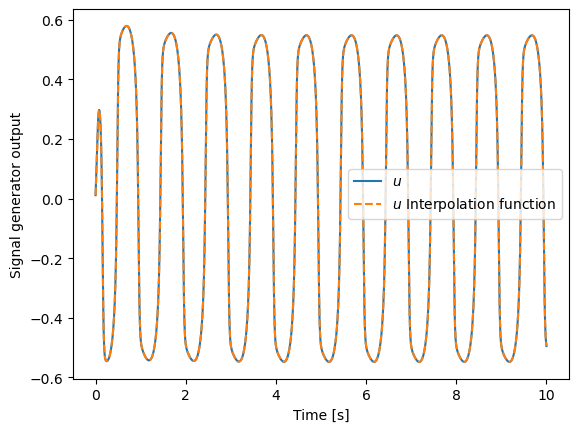

In [19]:
plt.figure()
plt.plot(time_vector.cpu().detach().numpy(), u_sim.cpu().detach().numpy(), linewidth=1.5, label='$u$')
plt.plot(time_vector.cpu().detach().numpy(), input_func(time_vector).cpu().detach().numpy(), linewidth=1.5, label='$u$ Interpolation function', linestyle = '--')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.ylabel('Signal generator output')

In [20]:
%%capture
plt.figure()
plt.plot(time_vector.cpu().detach().numpy(), (tau_sim[:, 0, :]).cpu().detach().numpy(), linewidth=1.5, label='$u$')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.ylabel('Signal generator states')

plt.figure()
plt.plot(time_vector.cpu().detach().numpy(), (w_sim[:, :]).cpu().detach().numpy(), linewidth=1.5, label='$u$')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.ylabel('Signal generator w')

In [21]:
if run_only_SG:
    raise KeyboardInterrupt

# Unknown system

## Generate and simulate system
Construct nodeREN that achieves a steady-state match

In [22]:
if not(load_sys):
    # Take a random c-nodeREN as the unknown system
    n  = 20
    nq = 20
    ny = 1
    sys_unknown = NODE_REN(n, ny, m, nq, sigma=sigma, epsilon=epsilon, mode='c',device=device, bias = 0, alpha=alpha_mod, u=input_func).to(device)
    
    # Remove parameters
    for param in sys_unknown.parameters():
        param.requires_grad = False
    sys_unknown.updateParameters()
    
else:
    # Load sys (and related variables)
    with open(path_sys, 'rb') as f:
        # n,nq,ny,x0,x_sim,y_sim,elapsed_time_sys,sys_unknown = pickle.load(f)
        n,nq,ny,x0,x_sim,y_sim,elapsed_time_sys,sys_unknown = pickle.load(f)

## Simulate the unknown system

In [23]:
if (not(load_sys) or sim_sys):
    start_time = time.time()
    x0         = torch.zeros(1,n)
    x_sim      = odeint(sys_unknown, x0, time_vector,method=sim_method, atol = atol, rtol = rtol)
    y_sim      = sys_unknown.output(time_vector, x_sim[:, 0, :])
    end_time   = time.time()
    elapsed_time_sys = end_time - start_time
    
    print(elapsed_time_sys)

## Save  system data

In [21]:
# Save sys data
if save_sys:
    with open(path_sys, 'wb') as f:
        pickle.dump((n,nq,ny,x0,x_sim,y_sim,elapsed_time_sys,sys_unknown), f)
    print('Saving completed')

## Plot system response

Text(0, 0.5, 'Output of the unknown system')

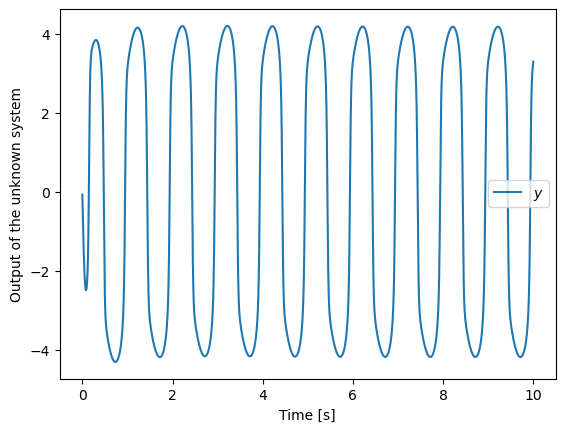

In [24]:
plt.figure()
plt.plot(time_vector.cpu().detach().numpy(), np.squeeze(y_sim.cpu().detach().numpy()), linewidth=1.5, label='$y$')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.ylabel('Output of the unknown system')

# Moment matching-based model
Generate a model that matches the steady-state of the system in a least-squares optimal way

## Linear least-squares regression for steady-state matching

In [25]:
if not(load_mm):
    lamb = 1e-3   # Regularisation constant

    # Solve regularised least-squares problem
    Xi, Omega, Phi, alpha, Y, ind = Linear_least_squares_mm(tau_sim,SG,time_vector,f0,w_sim.t(),n_SG,nqtilde,m,lamb)
    # Prediction using moment matching
    Ylsq = np.matmul(Phi,alpha)

else:
    # Load moment-matching parameters (and related variables)
    with open(path_mm, 'rb') as f:
        Xi,Omega,Phi,alpha,Y,Ylsq,ind = pickle.load(f)


# Xi, Omega, Phi, alpha, Y correspond to the variables in the paper
# ind is the indices in the time-vector corresponding to the last period

Text(0, 0.5, 'Least-squares prediction vs. unknown system output')

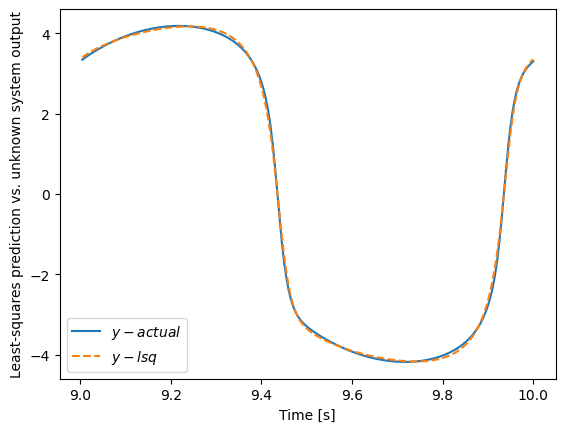

In [26]:
# Check the least-squares solution
plt.figure()
plt.plot(time_vector.cpu().detach().numpy()[ind], Y[ind], linewidth=1.5, label='$y-actual$')
plt.plot(time_vector.cpu().detach().numpy()[ind], Ylsq[ind], linewidth=1.5, label='$y-lsq$',linestyle='dashed')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.ylabel('Least-squares prediction vs. unknown system output')

In [27]:
# Save moment matching data
if save_mm:
    with open(path_mm, 'wb') as f:
        pickle.dump((Xi,Omega,Phi,alpha,Y,Ylsq,ind), f)
    print('Saving completed')

## Update model parameters

First we select a 'random' NodeREN. Then, we change its A, B1, B2, C1, D11, and D12 matrix.
We then simulate this model to get x_sim, w_sim.

In [29]:
# Randomly pick B2hat, D12hat until local stability is ensured
if not(load_mod):
    local_stab = False
    
    while not local_stab:
        B2hat = torch.randn(n_SG,m)*10
        D12hat = torch.randn(nqtilde,m)*10*0
        Jac = SG.sys.A.data-torch.matmul(B2hat,SG.sys.C2.data)+torch.matmul(SG.sys.B1.data,torch.matmul(torch.inverse(torch.eye(nqhat)-SG.sys.D11.data),SG.sys.C1.data-torch.matmul(D12hat,SG.sys.C2.data)))
        local_stab = all(np.real(torch.linalg.eig(Jac)[0])<-2)
    display(torch.linalg.eig(Jac)[0])
    # Make sure that the eigenvalues of Jac are in the OCLHP

In [30]:
# Initial model can be a generic non-contracting neural ODE
if not(load_mod):
    nxhat = n_SG
    nqhat = nqtilde
    
    Mod_mm = NODE_REN(nxhat, ny, m, nqhat, sigma, epsilon, mode='general',device=device, bias = 0, alpha=alpha_mod, u = input_func).to(device)
    Mod_mm.sys.D22.data = Mod_mm.sys.D22.data*0
    
    # Update parameters such that moment matching is achieved
    update_Mod_mm(Mod_mm,SG,B2hat,D12hat,Xi,Omega)
else:
    # Load model (and related variables)
    with open(path_mod, 'rb') as f:
        nxhat,nqhat,Mod_mm,x0_mod,xmod_sim,ymod_sim,wmod_sim,elapsed_time_mode = pickle.load(f)

## Simulate model

In [31]:
if (not(load_mod) or sim_mod):
    start_time = time.time()
    x0_mod     = torch.zeros(1,nxhat)
    xmod_sim   = odeint(Mod_mm, x0_mod, time_vector, method=sim_method, atol=atol, rtol=rtol)
    ymod_sim   = Mod_mm.output(time_vector, xmod_sim[:, 0, :])
    wmod_sim   = Mod_mm.sys.calculate_w(xmod_sim[:, 0, :],input_func(time_vector))
    end_time   = time.time()
    elapsed_time_mod = end_time - start_time
    print(elapsed_time_mod)

## Save model data

In [29]:
# Save model data
if save_mod:
    with open(path_mod, 'wb') as f:
        pickle.dump((nxhat,nqhat,Mod_mm,x0_mod,xmod_sim,ymod_sim,wmod_sim,elapsed_time_mod), f)
    print('Saving completed')

## Plot moment-matching model output

Text(0, 0.5, 'Output response')

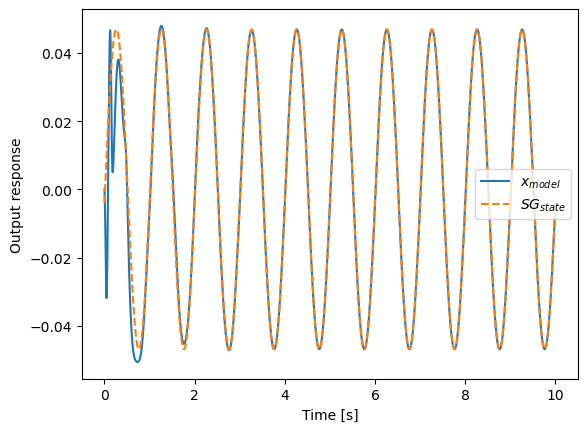

In [32]:
# %%capture 
# Figure used for debugging
plt.figure()
plt.plot(time_vector.cpu().detach().numpy(), np.squeeze(xmod_sim[:,:,0].cpu().detach().numpy()), linestyle='-', linewidth=1.5, label='$x_{model}$')
plt.plot(time_vector.cpu().detach().numpy(), np.squeeze(tau_sim[:,:,0].cpu().detach().numpy()), linestyle='--' ,linewidth=1.5, label='$SG_{state}$')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.ylabel('Output response')

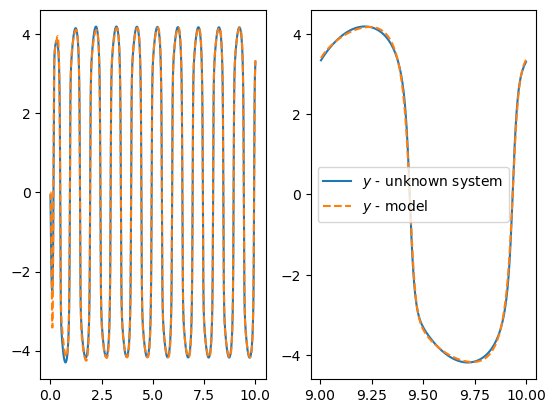

In [33]:
# plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(time_vector.cpu().detach().numpy(), np.squeeze(y_sim.cpu().detach().numpy()), linewidth=1.5, label='$y$ - unknown system')
ax1.plot(time_vector.cpu().detach().numpy(), np.squeeze(ymod_sim.cpu().detach().numpy()), linestyle='--', linewidth=1.5, label='$y$ - model')

ax2.plot(time_vector.cpu().detach().numpy()[ind], np.squeeze(y_sim.cpu().detach().numpy())[ind], linewidth=1.5, label='$y$ - unknown system')
ax2.plot(time_vector.cpu().detach().numpy()[ind], np.squeeze(ymod_sim.cpu().detach().numpy())[ind], linestyle='--', linewidth=1.5, label='$y$ - model')
plt.legend(loc='best')

# Multiple random models

## Construct random models and simulate

In [34]:
if not(load_mult):
    n_mod       = 20
    Mod_mm_list = []
    X_list      = []
    Y_list   = torch.zeros(n_steps,n_mod)
    x0_mod      = torch.zeros(1,nxhat)
    
    for k in range(n_mod):
    
        # Randomly pick B2hat, D12hat until local stability is ensured
        local_stab = False
        
        while not local_stab:
            B2hat = torch.randn(n_SG,m)*10
            D12hat = torch.randn(nqtilde,m)*10*0
            Jac = SG.sys.A.data-torch.matmul(B2hat,SG.sys.C2.data)+torch.matmul(SG.sys.B1.data,torch.matmul(torch.inverse(torch.eye(nqhat)-SG.sys.D11.data),SG.sys.C1.data-torch.matmul(D12hat,SG.sys.C2.data)))
            local_stab = all(np.real(torch.linalg.eig(Jac)[0])<-2)
        display(torch.linalg.eig(Jac)[0])
        # Make sure that the eigenvalues of Jac are in the OCLHP
        
        Mod_mm_list.append(NODE_REN(nxhat, ny, m, nqhat, sigma, epsilon, mode='general',device=device, bias = 0, alpha=alpha_mod, u = input_func).to(device))
        # Mod_mm.sys.D22.data = Mod_mm.sys.D22.data*0
        
        # Update parameters such that moment matching is achieved
        update_Mod_mm(Mod_mm_list[k],SG,B2hat,D12hat,Xi,Omega)
else:
    # Load data
    with open(path_mult, 'rb') as f:
        n_mod,Mod_mm_list,X_list,Y_list,x0_mod,elapsed_time_mult,time_vector = pickle.load(f)

In [35]:
# Simulate models
if (not(load_mult) or sim_mult):
    start_time = time.time()
    for k in range(n_mod):
        x_tmp = odeint(Mod_mm_list[k], x0_mod, time_vector)
        y_tmp = Mod_mm_list[k].output(time_vector, x_tmp[:, 0, :])
        X_list.append(x_tmp.squeeze())
        Y_list[:,k] = y_tmp.squeeze()
    print('Simulation completed')
    end_time          = time.time()
    elapsed_time_mult = end_time - start_time
    print(elapsed_time_mult)

## Save results

In [34]:
# Save multiple model data
if save_mult:
    with open(path_mult, 'wb') as f:
        pickle.dump((n_mod,Mod_mm_list,X_list,Y_list,x0_mod,elapsed_time_mult,time_vector), f)
    print('Saving completed')

## Plot the results

In [36]:
%%capture
# Plot all
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(time_vector.cpu().detach().numpy(), np.squeeze(y_sim.cpu().detach().numpy()), linewidth=1.5, label='$y$ (unknown system)')
ax1.plot(time_vector.cpu().detach().numpy(), np.squeeze(Y_list.cpu().detach().numpy()), linestyle='--', linewidth=1.5, label='$\hat{y}$ (model)')
ax1.set(xlabel = 'Time [s]',ylabel='Output response')


fig, (ax1) = plt.subplots(1, 1)
# ax1.plot(time_vector.cpu().detach().numpy(), np.squeeze(y_sim.cpu().detach().numpy()), linewidth=1.5, label='$y$ - unknown system')
ax1.plot(time_vector.cpu().detach().numpy(), np.squeeze(y_sim.cpu().detach().numpy()-Y_list.cpu().detach().numpy()), linestyle='--', linewidth=1.5, label='$y - \hat{y}$')
ax1.set(xlabel = 'Time [s]',ylabel='Error response')


[Text(0.5, 0, 'Time [s]'), Text(0, 0.5, 'Error response $(y-\\hat y)$')]

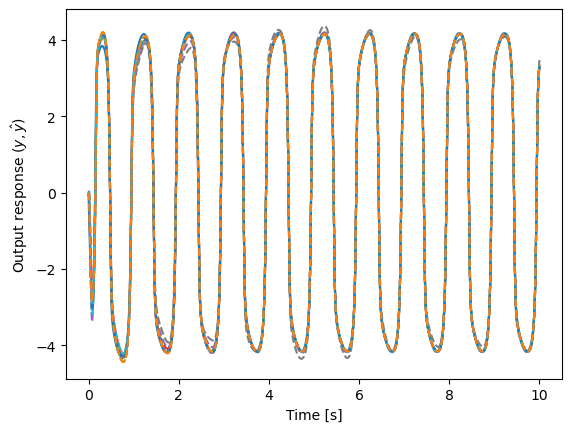

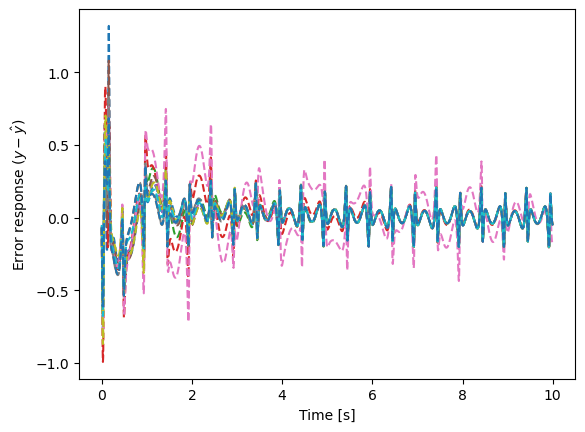

In [37]:
# Plot only a few
idx_new_plot = [0,1,2,3,4,5,6,7,8,10,1]
###### plt.figure()
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(time_vector.cpu().detach().numpy(), np.squeeze(y_sim.cpu().detach().numpy()), linewidth=1.5, label='$y$ - unknown system')
ax1.plot(time_vector.cpu().detach().numpy(), np.squeeze(Y_list.cpu().detach().numpy())[:,idx_new_plot], linestyle='--', linewidth=1.5, label='$\hat y$ - model')
ax1.set(xlabel = 'Time [s]',ylabel='Output response $(y,\hat y)$')

fig, (ax1) = plt.subplots(1, 1)
ax1.plot(time_vector.cpu().detach().numpy(), np.squeeze(y_sim.cpu().detach().numpy()-Y_list.cpu().detach().numpy())[:,idx_new_plot], linestyle='--', linewidth=1.5, label='$y - \hat y$')
ax1.set(xlabel = 'Time [s]',ylabel='Error response $(y-\hat y)$')
# ax1.legend(loc='best')

# Paper plots

In [38]:
# Toggle to save pictures
savefigs=0

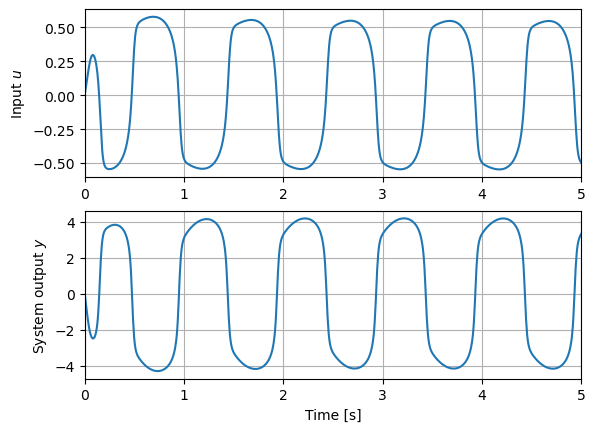

In [39]:
# Input-output plot
plt.figure()
plt.subplot(211)
plt.plot(time_vector.cpu().detach().numpy(), u_sim.cpu().detach().numpy(), linewidth=1.5)
plt.ylabel('Input $u$')
plt.xlim([0, 5])
plt.grid()

plt.subplot(212)
plt.plot(time_vector.cpu().detach().numpy(), y_sim.cpu().detach().numpy(), linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('System output $y$')
plt.xlim([0, 5])
plt.grid()
if savefigs:
    plt.savefig('Figures_ACC/Input-Output.pdf',bbox_inches='tight')

    plt.subplot(211)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('Input $u$', fontsize=14)
    plt.subplot(212)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time [s]', fontsize=14)
    plt.ylabel('System output $y$', fontsize=14)
    plt.savefig('Figures_ACC/Input-Output.svg',bbox_inches='tight')
    display('Figures printed')

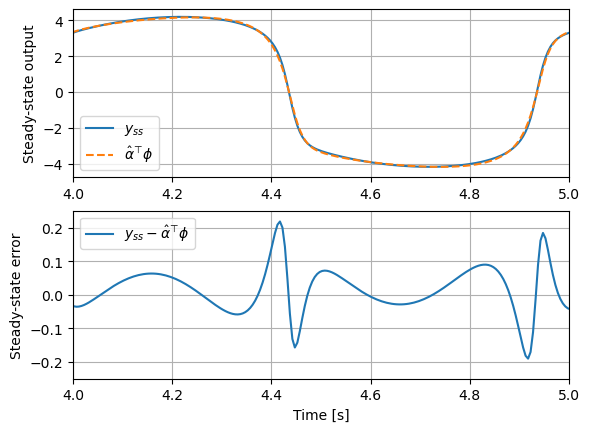

In [40]:
# Solution to the (regularised) least-sqaures problem

plt.figure()
plt.subplot(211)
plt.plot(time_vector.cpu().detach().numpy(), Y, label= r'$y_{ss}$', linewidth=1.5)
plt.plot(time_vector.cpu().detach().numpy(), Ylsq, label = r'$\hat{\alpha}^\top \phi$', linewidth=1.5,linestyle='dashed')
plt.legend(loc='best')
plt.ylabel('Steady-state output')
plt.xlim([4, 5])
plt.grid()

plt.subplot(212)
plt.plot(time_vector.cpu().detach().numpy(), Y-Ylsq, label= r'$y_{ss} - \hat{\alpha}^\top \phi$', linewidth=1.5)
plt.legend(loc='best')
plt.xlim([4, 5])
plt.ylim([-0.25, 0.25])
plt.xlabel('Time [s]')
plt.ylabel('Steady-state error')
plt.grid()
if savefigs:
    plt.savefig('Figures_ACC/LSQ.pdf',bbox_inches='tight') 

    plt.subplot(211)
    plt.ylabel('Steady-state output', fontsize=14)
    plt.legend(loc=1,fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.subplot(212)
    plt.xlabel('Time [s]', fontsize=14)
    plt.ylabel('Steady-state error', fontsize=14)
    plt.legend(loc=1,fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig('Figures_ACC/LSQ.svg',bbox_inches='tight')
    display('Figures printed')

In [41]:
# Print performance figures
E = Y-Ylsq
E_ss = np.squeeze(E[ind])
E_mse = np.inner(E_ss,E_ss)/np.size(E_ss)

Y_ss = np.squeeze(Y[ind])
Y_mse = np.inner(Y_ss,Y_ss)/np.size(Y_ss)

print(E_mse)
print(Y_mse)

0.004415058934691569
13.123935546875


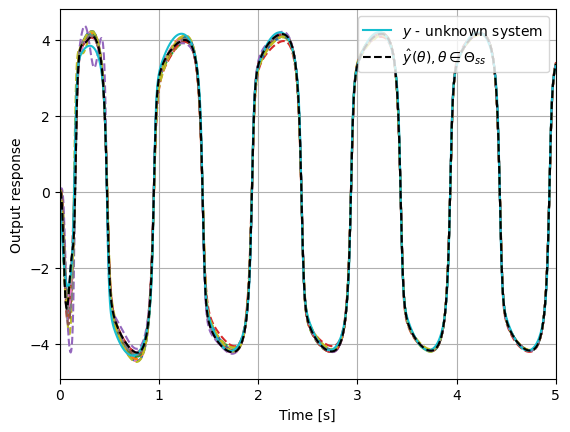

In [42]:
# Plot only a few
idx_plot = [0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19]
plt.plot(time_vector.cpu().detach().numpy(), np.squeeze(Y_list.cpu().detach().numpy())[:,idx_plot], linestyle='--', linewidth=1.5)
plt.plot(time_vector.cpu().detach().numpy(), np.squeeze(y_sim.cpu().detach().numpy()), linewidth=1.5, label='$y$ - unknown system')
plt.plot(time_vector.cpu().detach().numpy(), np.squeeze(Y_list.cpu().detach().numpy())[:,idx_plot[0]], color='k', linestyle='--', linewidth=1.5, label=r'$\hat y(\theta), \theta \in \Theta_{ss}$')
plt.xlabel('Time [s]')
plt.ylabel('Output response')
plt.legend(loc=1)
plt.grid()
plt.xlim([0, 5])

if savefigs:
    plt.savefig('Figures_ACC/Moment_matching_models.pdf',bbox_inches='tight')
    # Powerpoint
    # Get the current figure
    fig = plt.gcf()
    # Set the figure size (width, height) in inches
    plt.xlabel('Time [s]', fontsize=14)
    plt.ylabel('Output response', fontsize=14)
    plt.legend(loc=1,fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend().set_visible(False)
    plt.savefig('Figures_ACC/Moment_matching_models_font_size_update.svg')
    plt.legend(loc=1)
    fig.set_size_inches(16, 6)  # Width: 8 inches, Height: 6 inches
    plt.savefig('Figures_ACC/Moment_matching_models.svg')
    display('Figures printed')